# Create necessary framework

## Create the necessary training data 

In [1]:
library(tidyverse)
library(car)
library(olsrr)
library(stringr)
library(tidytext)
library(syuzhet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘car’ was built under R version 3.4.4”Loading required package: carData
Warning message:
“package ‘carData’ was built under R version 3.4.4”
Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘olsrr’

The following object is masked from ‘package:datasets’:

    rivers

Warning message:
“package ‘tidytext’ was built under R version 

In [2]:
# Make sure to change this
setwd("/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Text Analytics Project")

" 
Read in the CSV file
"
personality = as.tibble(read.csv("youtube-personality/YouTube-Personality-Personality_impression_scores_train.csv", 
                                 encoding = "UTF-8",
                                 sep = " "))

gender = as.tibble(read.csv("youtube-personality/YouTube-Personality-gender.csv",
                            encoding = "UTF-8",
                            sep = " "))

audiovisual = as.tibble(read.csv("youtube-personality/YouTube-Personality-audiovisual_features.csv",
                                 encoding = "UTF-8",
                                 sep = " "))

transcripts = as.tibble(read.csv("youtube-personality/transcripts.csv",
                                 encoding = "UTF-8",
                                 sep = ","))

transcripts$index = as.character(transcripts$index)

transcripts =
  transcripts %>%
  rename(vlogId = index,
         transcript = X0) %>%
  mutate(vlogId = substr(vlogId, 1, nchar(vlogId)-4))

personality$vlogId = as.character(personality$vlogId)
gender$vlogId = as.character(gender$vlogId)
audiovisual$vlogId = as.character(audiovisual$vlogId)

training_data = 
  personality %>%
  left_join(gender, on = c("vlogID" = "vlogID")) %>%
  left_join(audiovisual, on = c("vlogID" = "vlogID")) %>%
  left_join(transcripts, on = c("clogID" = "vlogID"))

#tokenization
training_data$transcript <- as.vector(training_data$transcript)
tidy_data <- training_data %>% 
  unnest_tokens(word, transcript, to_lower = TRUE) %>% 
  anti_join(get_stopwords())

#count the total number of words for each person
total_words <- tidy_data %>% 
  group_by(vlogId) %>% 
  count() %>% 
  rename(total_words = n)

#count the percentage of words related to big 5
words_E = c("bar","drinks", "restaurant", "dancing", "restaurants", "grandfather", "miami", "countless", "drinking", "shots", "girls", "glorious", "pool", "crowd", "sang", "grilled")
words_A = c("wonderful", "together", "visiting", "morning", "spring", "walked", "beautiful", "staying", "felt", "share", "gray", "joy", "afternoon", "day", "moments", "hug", "glad")
words_C = c("completed", "adventure", "adventures", "enjoying", "hawaii", "it's", "deck")
words_N = c("awful", "though", "lazy", "worse", "depressing", "irony", "terrible", "stressful", "horrible", "sort", "annoying", "ashamed", "ban")
words_O = c("folk", "humans", "of", "poet", "art", "by", "universe", "poetry", "narrative", "culture", "century", "sexual", "films", "novel", "decades", "ink", "passage", "literature", "blues")
words_nE = c("other", "cats", "computer", "minor")
words_nA = c("porn", "cost", "fuck")
words_nC = c("stupid", "boring", "desperate", "saying", "utter", "it's", "extreme")
words_nN = c("road", "southern", "visited", "ground", "oldest", "invited", "completed")
words_nO = c("giveaway")

check_words <- function(wordlist){
  tidy_data %>% 
    filter(word %in% wordlist) %>% 
    group_by(vlogId) %>% 
    count() %>% 
    left_join(total_words) %>% 
    mutate(n/total_words) %>% 
    select(-n, -total_words)
}

E_words <- check_words(words_E) %>% 
  rename(words_Extraversion = 'n/total_words')

A_words <- check_words(words_A) %>% 
  rename(words_Agreeableness = 'n/total_words')

C_words <- check_words(words_C) %>% 
  rename(words_Conscientiousness = 'n/total_words')

N_words <- check_words(words_N) %>% 
  rename(words_Neuroticism = 'n/total_words')

O_words <- check_words(words_O) %>% 
  rename(words_Openness = 'n/total_words')

nE_words <- check_words(words_nE) %>% 
  rename(words_nExtraversion = 'n/total_words')

nA_words <- check_words(words_nA) %>% 
  rename(words_nAgreeableness = 'n/total_words')

nC_words <- check_words(words_nC) %>% 
  rename(words_nConscientiousness = 'n/total_words')

nN_words <- check_words(words_nN) %>% 
  rename(words_nNeuroticism = 'n/total_words')

nO_words <- check_words(words_nO) %>% 
  rename(words_nOpenness = 'n/total_words')

#putting them bag to the training data
training_data <- training_data %>% 
  left_join(E_words) %>%
  left_join(A_words) %>%
  left_join(C_words) %>%
  left_join(N_words) %>%
  left_join(O_words) %>%
  left_join(nE_words) %>%
  left_join(nA_words) %>%
  left_join(nC_words) %>%
  left_join(nN_words) %>%
  left_join(nO_words) %>% 
  replace(., is.na(.), 0)

#sentiment analysis with nrc
nrc <- tidy_data %>% 
  inner_join(get_sentiments('nrc')) %>%
  count(`vlogId`, sentiment) %>%
  spread(sentiment, n, fill = 0)

training_data <- training_data %>% 
  left_join(nrc) %>%
  left_join(total_words) %>%
  mutate(anger = anger / total_words,
         anticipation = anticipation / total_words,
         disgust = disgust / total_words,
         fear = fear / total_words,
         joy = joy / total_words,
         negative = negative / total_words,
         positive = positive / total_words,
         sadness = sadness / total_words,
         surprise = surprise / total_words,
         trust = trust / total_words) %>%
  select(-total_words)

# sentiment scores from syuzhet package - positive = positive emotions, 
# negative = negative emotions
training_data$sentiment <- get_sentiment(
    as.vector(training_data$transcript), method = "afinn")

training_data = 
    training_data %>%
    select(-transcript)

[1] " \nRead in the CSV file\n"

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"


## Standardise the data

In [3]:
temp1 = 
    training_data %>%
    select(-vlogId, - gender,
           - Extr:-Open) %>%
    scale()

training_data = 
    training_data %>%
    select(vlogId, gender,
           Extr:Open) %>%
    cbind(temp1)

# Modelling Extraversion

## Baseline model 

In the baseline model, all the features are included.

In [4]:
training_data = training_data[,c(2:3,8:53)]

In [5]:
baseline = lm(Extr ~ ., data = training_data)

In [6]:
summary(baseline)


Call:
lm(formula = Extr ~ ., data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.27493 -0.52774 -0.01634  0.50987  1.98687 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.446635   0.082556  53.862  < 2e-16 ***
genderMale                0.356647   0.141788   2.515 0.012460 *  
mean.pitch                0.152054   0.088027   1.727 0.085221 .  
sd.pitch                  0.047267   0.088442   0.534 0.593462    
mean.conf.pitch           0.242982   0.151499   1.604 0.109891    
sd.conf.pitch            -0.059080   0.095660  -0.618 0.537348    
mean.spec.entropy         0.157750   0.142858   1.104 0.270451    
sd.spec.entropy          -0.098557   0.086688  -1.137 0.256559    
mean.val.apeak           -0.005789   0.105498  -0.055 0.956278    
sd.val.apeak              0.170000   0.083661   2.032 0.043110 *  
mean.loc.apeak            0.231503   0.118039   1.961 0.050857 .  
sd.loc.apeak             

Warning message:
“not plotting observations with leverage one:
  28”Warning message:
“not plotting observations with leverage one:
  28”

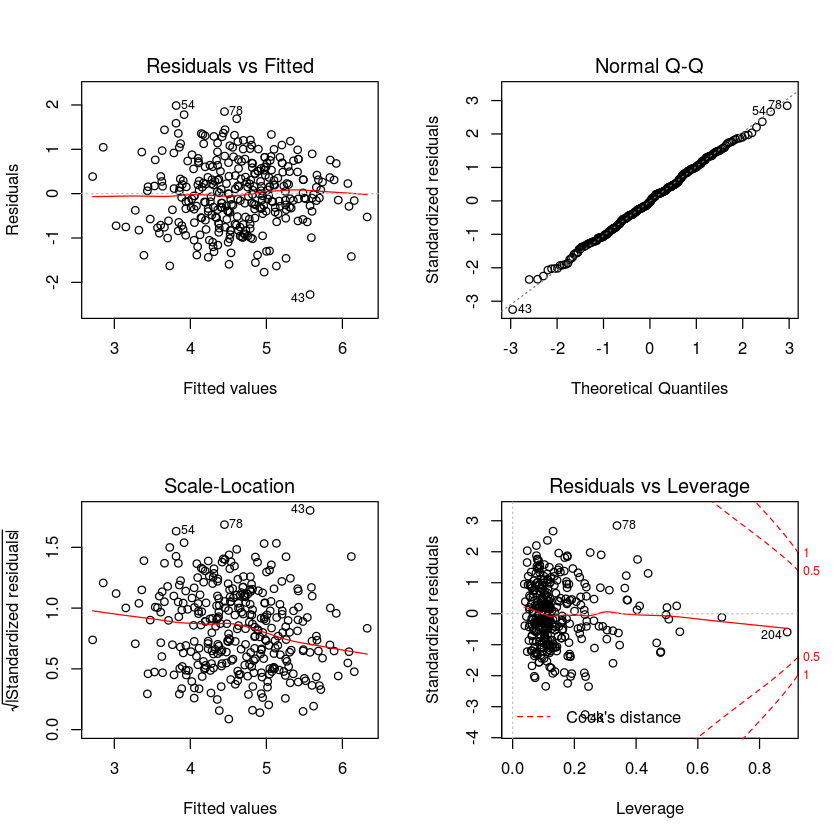

In [7]:
par(mfrow = c(2,2))
plot(baseline)

In [8]:
vif(baseline)[vif(baseline) > 10]

mean.conf.pitch mean.spec.entropy    mean.num.apeak    avg.voiced.seg 
         11.59118          10.30668          11.74448          11.60390

**Adjusted R-squared:** 0.3147. 

It may be a good idea to remove multi-collinear variables before backward selection (based on a p-threshold of < 0.3) as multicollinear variables may lead to inflated p-values.

Here, multicollinear variables are identified as those having a VIF > 10. Those variables are:

- mean.conf.pitch
- mean.spec.entropy
- mean.num.apeak
- avg.voiced.seg

## Model 2
In model 2, we try to reduce multicollinearity as a precursor the backward selection. We do this by removing certain features.

In [9]:
model2 = update(baseline, ~. 
                -mean.spec.entropy 
                -mean.num.apeak 
                -mean.conf.pitch)

We removed **mean.spec.entropy**, **mean.num.apeak**, and **mean.conf.pitch**. Now, no variables have a VIF of higher than 10.

In [10]:
summary(model2)


Call:
lm(formula = Extr ~ gender + mean.pitch + sd.pitch + sd.conf.pitch + 
    sd.spec.entropy + mean.val.apeak + sd.val.apeak + mean.loc.apeak + 
    sd.loc.apeak + sd.num.apeak + mean.energy + sd.energy + mean.d.energy + 
    sd.d.energy + avg.voiced.seg + avg.len.seg + time.speaking + 
    voice.rate + num.turns + hogv.entropy + hogv.median + hogv.cogR + 
    hogv.cogC + words_Extraversion + words_Agreeableness + words_Conscientiousness + 
    words_Neuroticism + words_Openness + words_nExtraversion + 
    words_nAgreeableness + words_nConscientiousness + words_nNeuroticism + 
    words_nOpenness + anger + anticipation + disgust + fear + 
    joy + negative + positive + sadness + surprise + trust + 
    sentiment, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3245 -0.5111 -0.0337  0.5558  1.9904 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.438050   0.082107  54.052  < 2e-16 ***
gender

## Model 3
In model 3, we integrate **backward selection** by removing features with p-values higher than 0.3.

In [11]:
to_remove = ols_step_backward(model2)

We are eliminating variables based on p value...
No more variables satisfy the condition of prem: 0.3


These features had a p-value > 0.3. We therefore remove them from the regression:

- avg.voiced.seg
- negative
- anticipation
- sd.pitch
- sd.energy
- words_nExtraversion
- words_nAgreeableness
- words_Openness
- joy
- hogv.cogC
- sd.num.apeak
- words_Neuroticism
- words_Agreeableness
- words_nOpenness
- fear
- mean.val.apeak
- surprise
- words_nNeuroticism
- sadness
- sd.conf.pitch
- hogv.median
- disgust

In [12]:
paste(to_remove$removed, collapse = " - ")

[1] "avg.voiced.seg - negative - anticipation - sd.pitch - sd.energy - words_nExtraversion - words_nAgreeableness - words_Openness - joy - hogv.cogC - sd.num.apeak - words_Neuroticism - words_Agreeableness - words_nOpenness - fear - mean.val.apeak - surprise - words_nNeuroticism - sadness - sd.conf.pitch - hogv.median - disgust"

In [13]:
model3 = update(model2, ~. - avg.voiced.seg - negative - anticipation - sd.pitch 
                           - sd.energy - words_nExtraversion - words_nAgreeableness 
                           - words_Openness - joy - hogv.cogC - sd.num.apeak - words_Neuroticism
                           - words_Agreeableness - words_nOpenness - fear 
                           - mean.val.apeak - surprise - words_nNeuroticism 
                           - sadness - sd.conf.pitch - hogv.median - disgust)

In [14]:
summary(model3)


Call:
lm(formula = Extr ~ gender + mean.pitch + sd.spec.entropy + sd.val.apeak + 
    mean.loc.apeak + sd.loc.apeak + mean.energy + mean.d.energy + 
    sd.d.energy + avg.len.seg + time.speaking + voice.rate + 
    num.turns + hogv.entropy + hogv.cogR + words_Extraversion + 
    words_Conscientiousness + words_nConscientiousness + anger + 
    positive + trust + sentiment, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3759 -0.5170 -0.0043  0.5575  1.9617 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.46299    0.07213  61.876  < 2e-16 ***
genderMale                0.32333    0.11769   2.747  0.00637 ** 
mean.pitch                0.13305    0.05314   2.504  0.01282 *  
sd.spec.entropy          -0.09838    0.05543  -1.775  0.07694 .  
sd.val.apeak              0.14687    0.05425   2.707  0.00717 ** 
mean.loc.apeak            0.26713    0.05645   4.732 3.42e-06 ***
sd.loc.apeak             -0.21

## Model 4
Remove rows where absolute studentized residual exceeded 3.

In [15]:
outlierTest(model3)

No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
    rstudent unadjusted p-value Bonferonni p
43 -3.372437         0.00084281      0.27307

In [16]:
training_data = training_data[-43,]

In [17]:
model4 = update(model2, ~. - avg.voiced.seg - negative - anticipation - sd.pitch 
                           - sd.energy - words_nExtraversion - words_nAgreeableness 
                           - words_Openness - joy - hogv.cogC - sd.num.apeak - words_Neuroticism
                           - words_Agreeableness - words_nOpenness - fear 
                           - mean.val.apeak - surprise - words_nNeuroticism 
                           - sadness - sd.conf.pitch - hogv.median - disgust)

In [18]:
summary(model4)


Call:
lm(formula = Extr ~ gender + mean.pitch + sd.spec.entropy + sd.val.apeak + 
    mean.loc.apeak + sd.loc.apeak + mean.energy + mean.d.energy + 
    sd.d.energy + avg.len.seg + time.speaking + voice.rate + 
    num.turns + hogv.entropy + hogv.cogR + words_Extraversion + 
    words_Conscientiousness + words_nConscientiousness + anger + 
    positive + trust + sentiment, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.69955 -0.53531 -0.02822  0.55765  1.93195 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.44808    0.07105  62.601  < 2e-16 ***
genderMale                0.37131    0.11658   3.185  0.00160 ** 
mean.pitch                0.17276    0.05356   3.225  0.00140 ** 
sd.spec.entropy          -0.10193    0.05451  -1.870  0.06246 .  
sd.val.apeak              0.13278    0.05351   2.481  0.01363 *  
mean.loc.apeak            0.25518    0.05561   4.589 6.56e-06 ***
sd.loc.apeak        

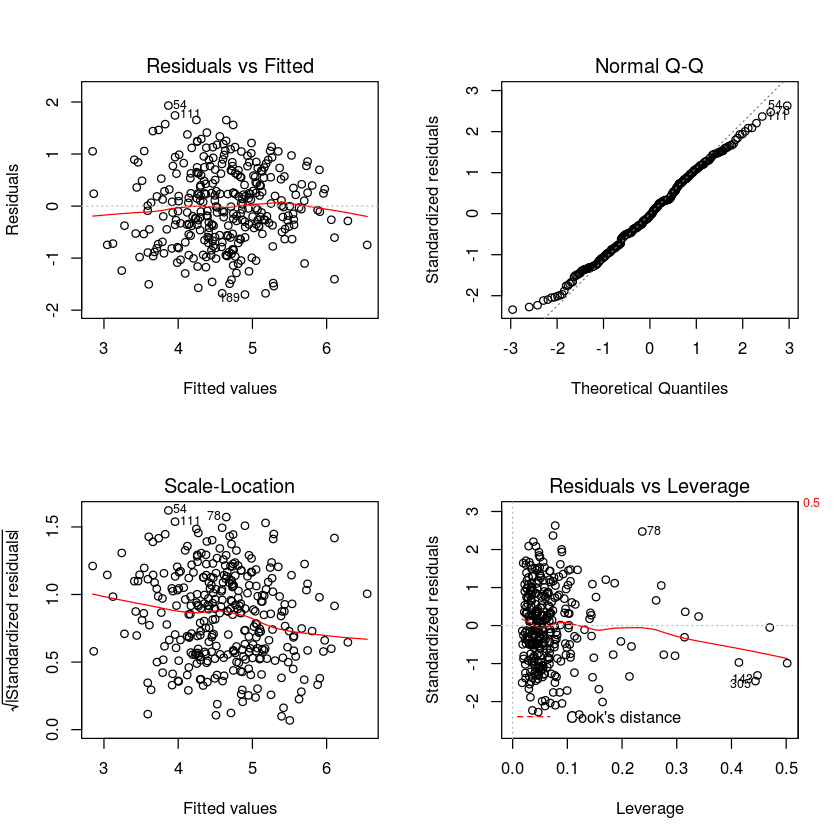

In [19]:
par(mfrow = c(2,2))
plot(model4)

## Model 5
Modelling non-linear relationships.

#### Scatterplots give indications of non-linear relationships between Extr and the features.

In [20]:
training_data = 
    training_data %>%
    select(Extr, gender, mean.pitch,
          sd.spec.entropy, sd.val.apeak,
          mean.loc.apeak, sd.loc.apeak,
          mean.energy, mean.d.energy, sd.d.energy, 
          avg.len.seg, time.speaking, voice.rate,
          num.turns, hogv.entropy, hogv.cogR,
          words_Extraversion, words_Conscientiousness,
          words_nConscientiousness, anger,
          positive, trust, sentiment)

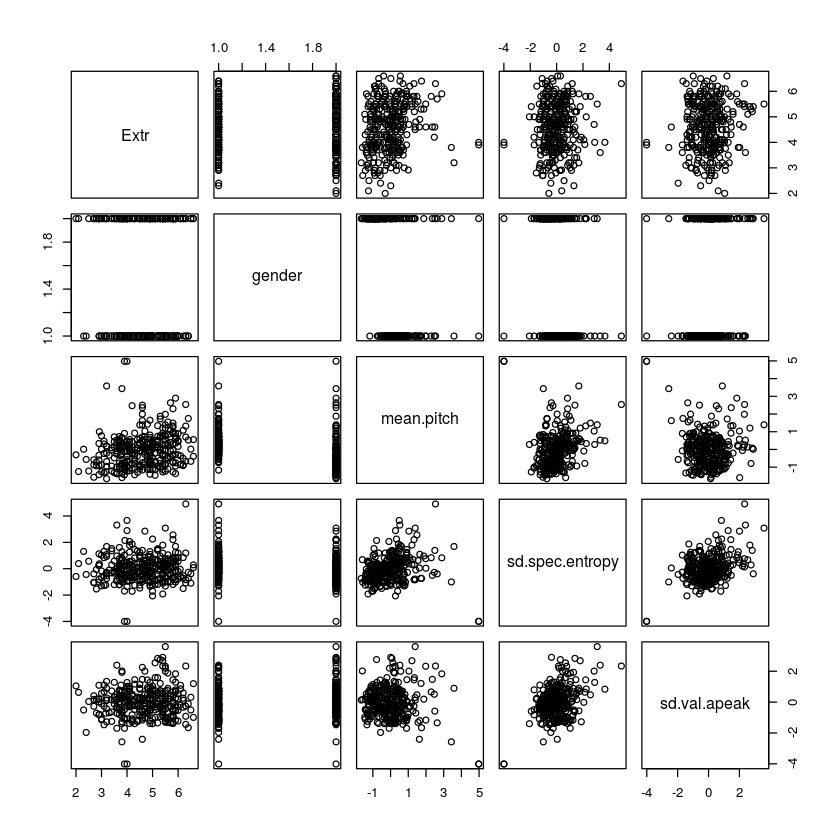

In [23]:
pairs(training_data[,c(1:5)])

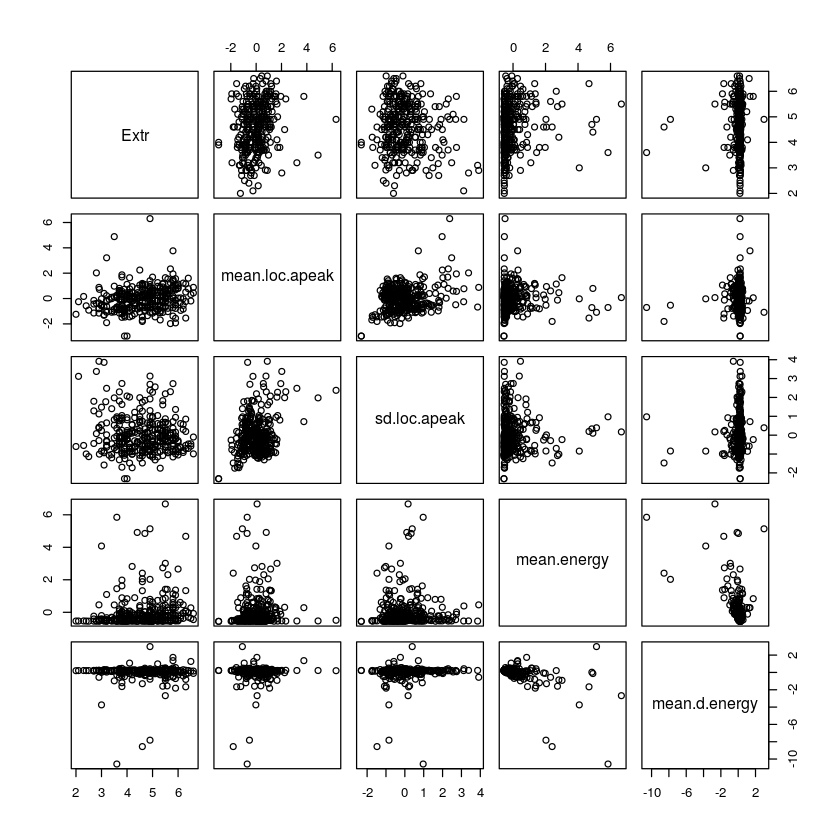

In [27]:
pairs(training_data[,c(1, 6:9)])

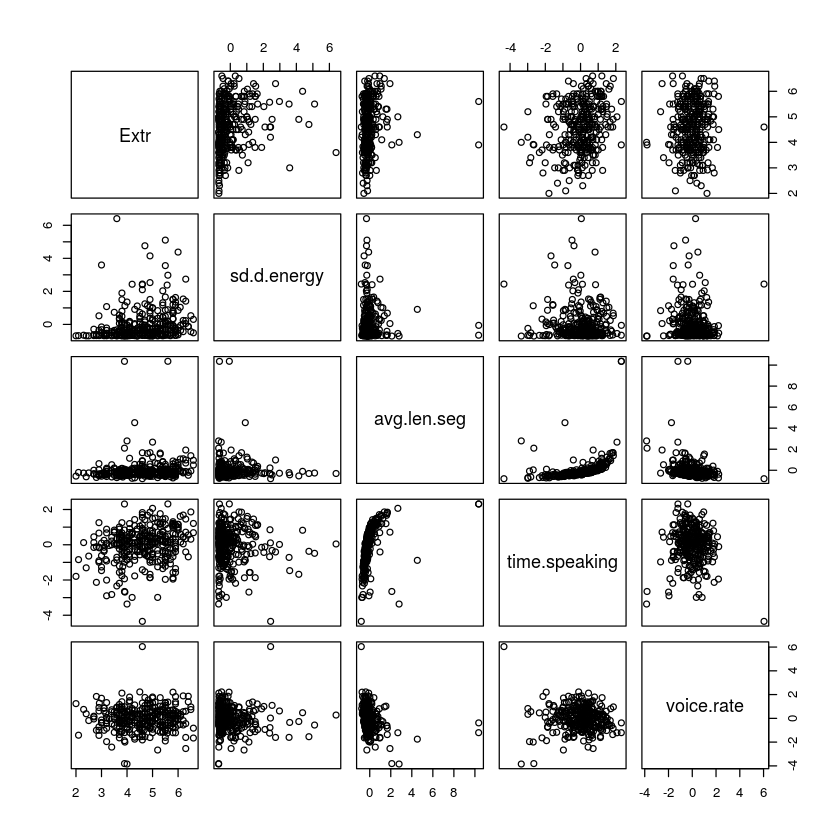

In [29]:
pairs(training_data[,c(1, 10:13)])

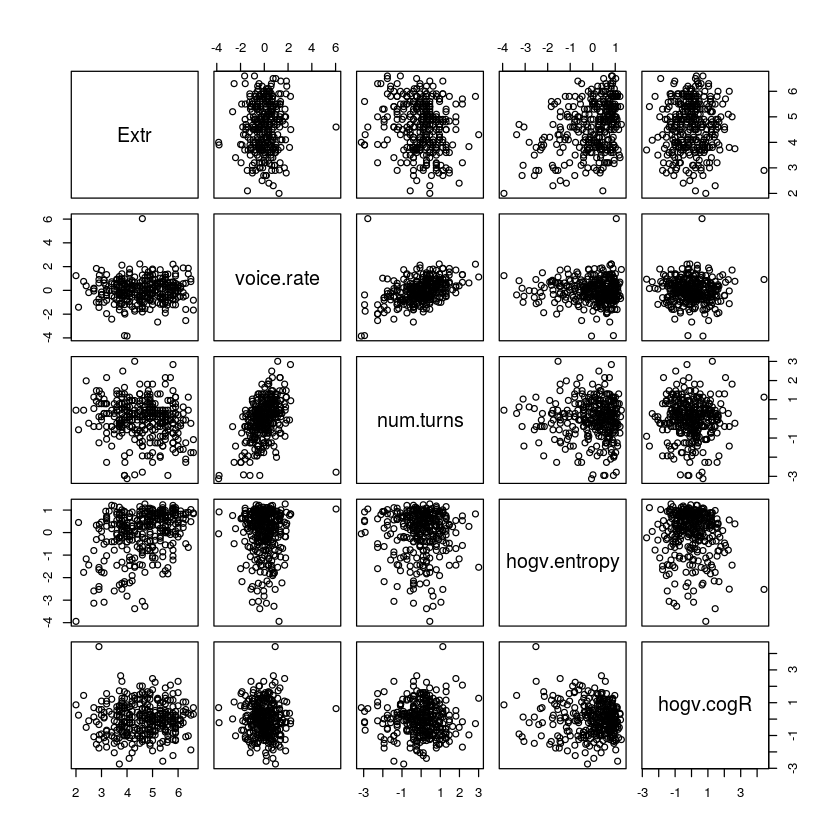

In [30]:
pairs(training_data[,c(1, 13:16)])

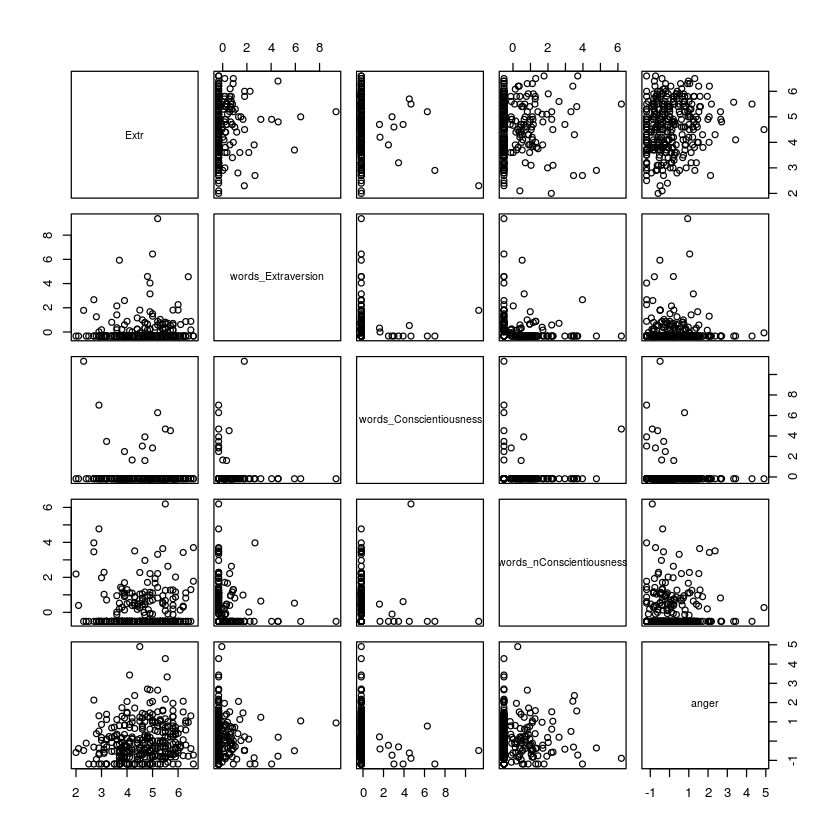

In [32]:
pairs(training_data[,c(1, 17:20)])

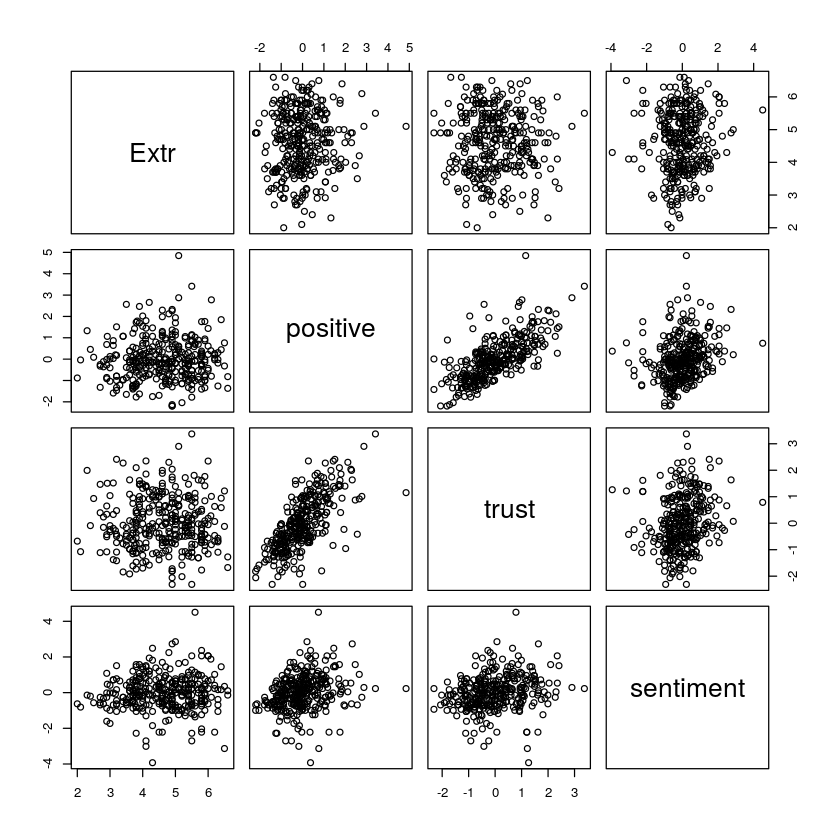

In [35]:
pairs(training_data[,c(1, 21:23)])

The model may benefit by fitting a quadratic feature for **sd.d.energy** and **mean.energy**.

In [36]:
model5 = update(model4, ~. + I(sd.d.energy**2) + I(mean.energy**2))

In [37]:
summary(model5)


Call:
lm(formula = Extr ~ gender + mean.pitch + sd.spec.entropy + sd.val.apeak + 
    mean.loc.apeak + sd.loc.apeak + mean.energy + mean.d.energy + 
    sd.d.energy + avg.len.seg + time.speaking + voice.rate + 
    num.turns + hogv.entropy + hogv.cogR + words_Extraversion + 
    words_Conscientiousness + words_nConscientiousness + anger + 
    positive + trust + sentiment + I(sd.d.energy^2) + I(mean.energy^2), 
    data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.69347 -0.52041 -0.01383  0.55622  1.89293 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.50435    0.07532  59.801  < 2e-16 ***
genderMale                0.33160    0.11598   2.859 0.004548 ** 
mean.pitch                0.17213    0.05306   3.244 0.001314 ** 
sd.spec.entropy          -0.11595    0.05410  -2.143 0.032898 *  
sd.val.apeak              0.12844    0.05308   2.420 0.016129 *  
mean.loc.apeak            0.23961    0.0553

## Model 6
Modeling interactions with gender. 

In [92]:
model6 = update(model5, ~. + gender*words_nConscientiousness
                           + gender*hogv.entropy
                           + gender*positive)

In [94]:
summary(model6)


Call:
lm(formula = Extr ~ gender + mean.pitch + sd.spec.entropy + sd.val.apeak + 
    mean.loc.apeak + sd.loc.apeak + mean.energy + mean.d.energy + 
    sd.d.energy + avg.len.seg + time.speaking + voice.rate + 
    num.turns + hogv.entropy + hogv.cogR + words_Extraversion + 
    words_Conscientiousness + words_nConscientiousness + anger + 
    positive + trust + sentiment + I(sd.d.energy^2) + I(mean.energy^2) + 
    gender:words_nConscientiousness + gender:hogv.entropy + gender:positive, 
    data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.57613 -0.50618 -0.02551  0.48580  2.06784 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          4.52759    0.07416  61.054  < 2e-16 ***
genderMale                           0.32959    0.11361   2.901  0.00400 ** 
mean.pitch                           0.16545    0.05234   3.161  0.00174 ** 
sd.spec.entropy                     -0.11054    0.05

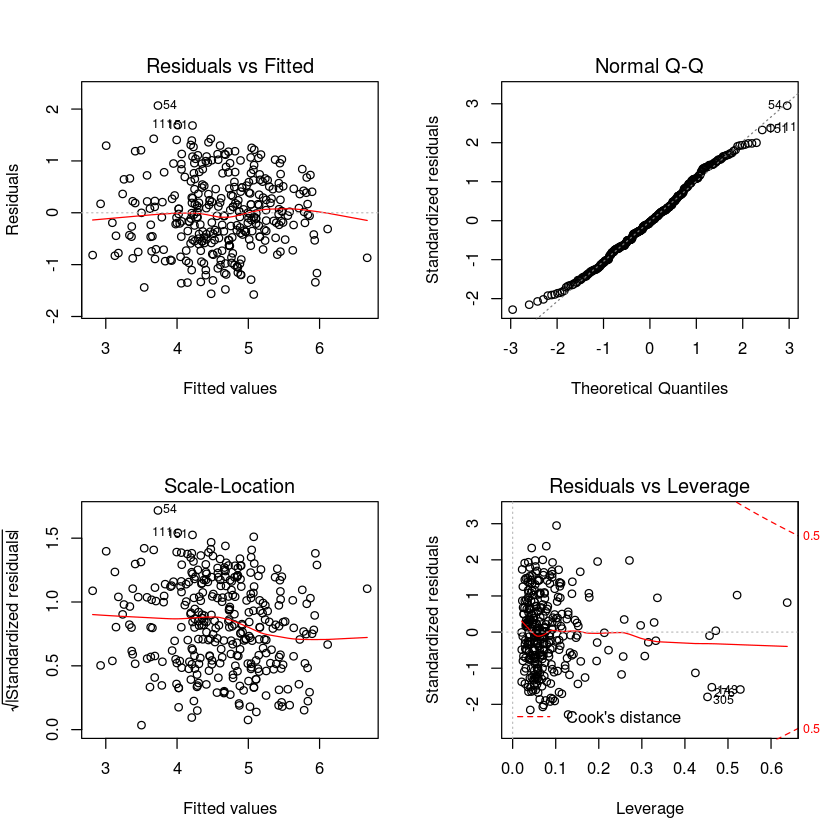

In [101]:
par(mfrow = c(2,2))
plot(model6)

In [104]:
predictors <- c("mean.pitch","sd.spec.entropy","sd.val.apeak", 
                  "mean.loc.apeak", "sd.loc.apeak","mean.energy","mean.d.energy",
                  "sd.d.energy","avg.len.seg","time.speaking","voice.rate",
                  "num.turns","hogv.entropy","hogv.cogR","words_Extraversion",
                  "words_Conscientiousness","words_nConscientiousness","anger",
                  "positive","trust","sentiment","sd.d.energy","mean.energy")

In [128]:
summary(model6)


Call:
lm(formula = Extr ~ gender + mean.pitch + sd.spec.entropy + sd.val.apeak + 
    mean.loc.apeak + sd.loc.apeak + mean.energy + mean.d.energy + 
    sd.d.energy + avg.len.seg + time.speaking + voice.rate + 
    num.turns + hogv.entropy + hogv.cogR + words_Extraversion + 
    words_Conscientiousness + words_nConscientiousness + anger + 
    positive + trust + sentiment + I(sd.d.energy^2) + I(mean.energy^2) + 
    gender:words_nConscientiousness + gender:hogv.entropy + gender:positive, 
    data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.57613 -0.50618 -0.02551  0.48580  2.06784 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          4.52759    0.07416  61.054  < 2e-16 ***
genderMale                           0.32959    0.11361   2.901  0.00400 ** 
mean.pitch                           0.16545    0.05234   3.161  0.00174 ** 
sd.spec.entropy                     -0.11054    0.05